# Exploring the relationship Between Sea Surface Temperatures and Coral Bleaching

### Matthew Johnson - 2022 University of Rochester Master's in Data Science Candidate 

This notebook is part of an investigation to better understand sea surface temperature's impact on coral bleaching. Ultimately, the goal is to create a set of potential features to be included in a maching learning project to predict bleaching levels using a history of what the coral has been experiencing.  

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

# Load the Global Coral Bleaching Dataset (GCBD)

The Global Coral Bleaching Dataset (GCBD) is a database accessible at the link below. These researchers compiled seven coral bleaching datasets to one location and created a relational database to store their results and a number of other environmental factors. The below code takes an export of their "Query 1_Summary_Bleaching_Cover" and consolidates the last three target variables (Bleaching Prevelance, Bleaching Severity & Percent_Bleached_Sum) into one column (Percent_Bleached_Sum).

van Woesik, R., Kratochwill, C. A global coral-bleaching database, 1980–2020. Sci Data 9, 20 (2022). https://doi.org/10.1038/s41597-022-01121-y

In [2]:
#Must find better solution
def custom_Rounding(value):
    if(0 <= value % 1 < .5):
        return round(value) + .5
    elif(.5 <= value % 1 < 1):
        return round(value) - .5
    else:
        return round(value)

In [3]:
def LoadGCBD(path):
    
    #pull GCBD from user provided filepath
    df = pd.read_excel(path)
    
    #Data before 2004 is not present for MODIS GEE
    df = df.loc[df['Date_Year']>=2004]
    
    #Restrict to target locations <- Removed to maximize rows available
    #df = df.loc[(((df['Longitude_Degrees']> 142.69) & (df['Longitude_Degrees']<153.7) & (df['Latitude_Degrees']>-28.7)&(df['Latitude_Degrees']<-10)) 
    #                      | ((df['Longitude_Degrees']> -85) & (df['Longitude_Degrees']<-63) & (df['Latitude_Degrees']>17)&(df['Latitude_Degrees']<27)))]
    
    #df['Bleaching_Level'] = df['Bleaching_Level'].fillna('NA')
    
    #Only take 'Population' level results from reef check
    df = df.loc[df['Bleaching_Level']!= 'Colony']
    
    
    ##### Severity_Code #####
    #For Severity_Code, use the values that have both percent bleached to fill in categories of the categorical variable
    dfCodeConv = df[['Severity_Code','Percent_Bleached_Sum']].groupby(by='Severity_Code').median()
    dfCodeConv = dfCodeConv.rename(columns={'Percent_Bleached_Sum':'Per_Bleached_Sev'})
    
    #Join them back in to fill where percent bleached is already known
    df = df.join(dfCodeConv,on='Severity_Code')
    df.Percent_Bleached_Sum = np.where(df['Percent_Bleached_Sum'].isnull(),df['Per_Bleached_Sev'],df['Percent_Bleached_Sum'] )
    
    
    ##### Prevalence_Score #####
    #Convert Prevalence Score to percent bleaching by taking middle of percent ranges
    s1 = pd.Series(df['Bleaching_Prevalence_Score'].unique(),name = 'Bleaching_Prevalence_Score')
    s2 = pd.Series([5,np.nan,37.5,75,17.5,0.0],name = 'Per_Bleached_Prev')
    dfCodeConv = pd.concat([s1,s2],axis=1).set_index('Bleaching_Prevalence_Score')
    
    #Join values back in to provide the continuious variable conversion
    df = df.join(dfCodeConv,on='Bleaching_Prevalence_Score')
    df.Percent_Bleached_Sum = np.where(df['Percent_Bleached_Sum'].isnull(),df['Per_Bleached_Prev'],df['Percent_Bleached_Sum'] )
    
    # Convert date to match Modis data
    df = df.rename(columns={'Date_Year':'year','Date_Month':'month','Date_Day':'day'})
    df['day'] = df['day'].astype(str)
    df['month'] = df['month'].astype(str)
    df['year'] = df['year'].astype(str)
    #df['Date'] = pd.to_datetime(df[['year','month','day']])
    dfGCBD = df[['Latitude_Degrees','Longitude_Degrees','Percent_Bleached_Sum','day','month','year']]
    dfGCBD = dfGCBD[dfGCBD['Percent_Bleached_Sum'].notna()]
    
    #Round values to closest .5 to match average dataset
    dfGCBD['lat_Rnd'] = dfGCBD['Latitude_Degrees'].apply(custom_Rounding)
    dfGCBD['lon_Rnd'] = dfGCBD['Longitude_Degrees'].apply(custom_Rounding)

    return dfGCBD.reset_index()

dfGCBD = LoadGCBD('Data\Query 1_Summary_Bleaching_Cover.xlsx')
dfGCBD.sample(10)

,index,Latitude_Degrees,Longitude_Degrees,Percent_Bleached_Sum,day,month,year,lat_Rnd,lon_Rnd
5924,8754,7.020889,117.412889,5.00,13,7,2009,7.5,117.5
3238,3285,-16.424450,49.849533,30.32,20,5,2016,-16.5,49.5
5644,8124,6.389444,116.331194,0.00,19,10,2013,6.5,116.5
18759,35128,18.378000,-67.485000,98.30,15,12,2005,18.5,-67.5
4237,5234,2.888389,104.067222,0.00,31,3,2013,2.5,104.5
4355,5470,2.809361,104.135417,0.00,7,10,2011,2.5,104.5
2897,2944,26.222330,-80.077130,16.67,20,9,2016,26.5,-80.5
13344,25413,18.496194,-77.636944,0.25,20,11,2013,18.5,-77.5
8991,15655,-16.533639,-151.734333,0.00,26,5,2018,-16.5,-151.5
10753,19679,27.727611,34.257750,0.00,17,6,2008,27.5,34.5


Please note, percent_bleaching is not based on an exact method. Different studies will calcuate it in different ways with different spacial resolutions. Some may send a team of divers and average their observations, others may provide a volume of coral colonies bleached divided by coral colonies not bleached. Not that this status is an on or off switch, spectrums of bleaching further complicates this value.

# Goals from Outside Research to Implement

## Finding 1 - Temperatures one degree beyond summertime maximums led to increased risk of coral bleaching

Liu, G., Rauenzahn, J. L., Heron, S. F., Eakin, C. M., Skirving, W. J., Christensen, T., Strong, A. E., & Li, J. (2013). NOAA coral reef watch 50 km satellite sea surface temperature-based decision support system for coral bleaching management. Welcome to the NOAA Institutional Repository. Retrieved November 7, 2022, from https://repository.library.noaa.gov/view/noaa/743


## Finding 2 - Some bleaching at lower temperatures can be explained by periods rapid temperature growth, best described through a 14 day rolling coefficient of variation (CV)

Sammarco, P.W., Winter, A. & Stewart, J.C. Coefficient of variation of sea surface temperature (SST) as an indicator of coral bleaching. Mar Biol 149, 1337–1344 (2006). https://doi.org/10.1007/s00227-006-0318-0

# Finding Global Summer Max SST

Currently this takes the average of the top five hottest months to create a summertime maximum expectation. This is done at 1 degree latitude and logitude point intersections. Each point has monthly average temperatures from 1980 - 2022. I'd like to improve this by finding a dataset of monthly maximums and averaging those values over some space of time.

Data can be extracted from the netCDF link on this page 
http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/sst/datafiles.html

In [4]:
def Create_Monthly_SST_Averages(Path):
    
    #Load Dataset
    ds = xr.open_dataset(Path,decode_times=False)
    df = ds.to_dataframe()
    
    df = df.reset_index()
    df=df.rename(columns={'X':'Lon','Y':'Lat'})
    dfFnl = df[['Lat','Lon','T','sst']].copy()
    
    #Convert Lon from 1 - 360 to -180 - 180
    dfFnl['Lon'] = dfFnl['Lon'].where(df['Lon'] < 180, df['Lon']-360)
    
    dfSummer = dfFnl.groupby(['Lat','Lon'], group_keys=False).apply(pd.DataFrame.nlargest,n=5,columns='sst')
    dfSummer = dfSummer[['Lat','Lon','sst']].groupby(by=['Lat','Lon']).mean()
    
    dfSummer = dfSummer.reset_index()
    
    dfSummer = dfSummer.rename(columns={'sst':'sst_Summer'})
    
    return dfSummer
 
    
SummerAvgSST = Create_Monthly_SST_Averages('data/data.nc')

# An example of output
SummerAvgSST.loc[(SummerAvgSST['Lat']==24.5)& (SummerAvgSST['Lon']>=124.5)&(SummerAvgSST['Lon']<=130.5)]

,Lat,Lon,sst_Summer
41344,24.5,124.5,30.421926
41345,24.5,125.5,30.458876
41346,24.5,126.5,30.459566
41347,24.5,127.5,30.462780
41348,24.5,128.5,30.452358
41349,24.5,129.5,30.418478
41350,24.5,130.5,30.379467


C:\Users\matjo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matjo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sst_Summer', ylabel='Density'>

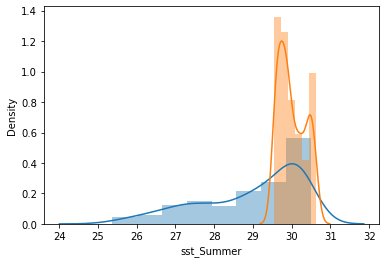

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

SummerAvgSSTDist1 = SummerAvgSST.loc[(SummerAvgSST['Lon']> 142.69) & (SummerAvgSST['Lon']<153.7) & (SummerAvgSST['Lat']>-28.7)&(SummerAvgSST['Lat']<-10)]
SummerAvgSSTDist2 = SummerAvgSST.loc[(SummerAvgSST['Lon']> -85) & (SummerAvgSST['Lon']<-63) & (SummerAvgSST['Lat']>17)&(SummerAvgSST['Lat']<27)]

sns.distplot(SummerAvgSSTDist1['sst_Summer'],ax=ax)
sns.distplot(SummerAvgSSTDist2['sst_Summer'],ax=ax)

The above chart shows summer expectations for the Great Barrier Reef (blue) and the Carribean (Orange). This shows the need to contexulaize SST by location since different regions experience vastly different temperatures.

# Extract Modis Data

In [6]:
import ee
from ee import EEException
import pandas as pd
ee.Authenticate(quiet=True)
ee.Initialize()

Paste the following address into a web browser:

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=bjqKyGAILOrI199KzFTUXLKZs1L4j1hT6xO2yxoF_Ek&tc=2GD7drg3mAqbDHYSvLCRovnGRCHQPGMLWywHFeyvApA&cc=V-IDh0kaEcIouB083Hidz_3NwZxB5WHNso3GnvhqsVc

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --code-verifier=bjqKyGAILOrI199KzFTUXLKZs1L4j1hT6xO2yxoF_Ek:nloG4_JE09EVGbIUrPwUmCA8LiJjicqSb1bCSUDX0Xc:l9dThypP-wjOh3EDX6UQAJYG6IRyG7MYggskabL3rws --authorization-code=PLACE_AUTH_CODE_HERE

Enter verification code: 4/1AfgeXvu2ULsZyGE7ZOYpf9pfF9u12ep8gZwiZNaGcOlb79-7LBWWbZdB56A

Successfully saved authorization token.


# Indv Row Testing

The following cells break down the steps of the above functions to highlight how features are extracted from the SST history per each row of coral study

In [28]:
row = dfGCBD.iloc[1370] #1370 <-Good example

chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['sst'])
date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
image = chlor.filterBounds(geometry=point).filterDate(date.advance(-90, 'day'), date)
data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
df = pd.DataFrame(data[1:], columns=data[0])
df['lat_Rnd'] = row['lat_Rnd']
df['lon_Rnd'] = row['lon_Rnd']

df

,id,longitude,latitude,time,sst,lat_Rnd,lon_Rnd
0,A2015156,-81.095412,24.636297,1433463901000,NaN,24.5,-81.5
1,A2015157,-81.095412,24.636297,1433552401000,29.984999,24.5,-81.5
2,A2015158,-81.095412,24.636297,1433636100000,28.775000,24.5,-81.5
3,A2015159,-81.095412,24.636297,1433724601000,28.434999,24.5,-81.5
4,A2015160,-81.095412,24.636297,1433808300000,28.639999,24.5,-81.5
...,...,...,...,...,...,...,...
85,A2015241,-81.095412,24.636297,1440808800000,NaN,24.5,-81.5
86,A2015242,-81.095412,24.636297,1440892801000,NaN,24.5,-81.5
87,A2015243,-81.095412,24.636297,1440981001000,30.760000,24.5,-81.5
88,A2015244,-81.095412,24.636297,1441068301000,30.320000,24.5,-81.5


The above dataframe is the raw SST history extraction from modis. A single bleaching row has been sent to their database and a 90 day history is retreived. Notice some NaNs are present where data was not available. Also, the time is the number of milliseconds since 1970-01-01.

In [29]:
#fill NaNs with with interpolated values from closest known rows
df['sst_extended'] = df['sst'].interpolate()

#Merge Summer averages with rounded coordinates
dfExt=pd.merge(df,SummerAvgSST,how='left',left_on=['lon_Rnd','lat_Rnd'],right_on = ['Lon','Lat'])

#Compute statistics
dfExt['sst_SumComp'] = dfExt['sst_extended']-dfExt['sst_Summer']
dfExt['sst_sd'] = dfExt['sst_extended'].rolling(14).std()
dfExt['sst_mean'] = dfExt['sst_extended'].rolling(14).mean()
dfExt['sst_cv'] = dfExt['sst_sd']*100/dfExt['sst_mean']
dfExt#[['longitude','latitude','time','sst','sst_SumComp','sst_cv']]

,id,longitude,latitude,time,sst,lat_Rnd,lon_Rnd,sst_extended,Lat,Lon,sst_Summer,sst_SumComp,sst_sd,sst_mean,sst_cv
0,A2015156,-81.095412,24.636297,1433463901000,NaN,24.5,-81.5,NaN,24.5,-81.5,30.540913,NaN,NaN,NaN,NaN
1,A2015157,-81.095412,24.636297,1433552401000,29.984999,24.5,-81.5,29.984999,24.5,-81.5,30.540913,-0.555914,NaN,NaN,NaN
2,A2015158,-81.095412,24.636297,1433636100000,28.775000,24.5,-81.5,28.775000,24.5,-81.5,30.540913,-1.765913,NaN,NaN,NaN
3,A2015159,-81.095412,24.636297,1433724601000,28.434999,24.5,-81.5,28.434999,24.5,-81.5,30.540913,-2.105913,NaN,NaN,NaN
4,A2015160,-81.095412,24.636297,1433808300000,28.639999,24.5,-81.5,28.639999,24.5,-81.5,30.540913,-1.900913,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,A2015241,-81.095412,24.636297,1440808800000,NaN,24.5,-81.5,30.664000,24.5,-81.5,30.540913,0.123087,0.351815,30.665749,1.147256
86,A2015242,-81.095412,24.636297,1440892801000,NaN,24.5,-81.5,30.712000,24.5,-81.5,30.540913,0.171087,0.233985,30.603392,0.764572
87,A2015243,-81.095412,24.636297,1440981001000,30.760000,24.5,-81.5,30.760000,24.5,-81.5,30.540913,0.219088,0.229082,30.598035,0.748681
88,A2015244,-81.095412,24.636297,1441068301000,30.320000,24.5,-81.5,30.320000,24.5,-81.5,30.540913,-0.220913,0.215063,30.552500,0.703914


This dataframe is the result of taking the Modis data and building the larger context and statistics to be used for feature extraction. First the SST data is interpolated. Then the temperatures are compared to the locations summertime expectations and rolling 14 day CV is calculated from the mean and standard deviation.

The following chart plots this data over the 90 day sample history.

<Figure size 432x288 with 0 Axes>

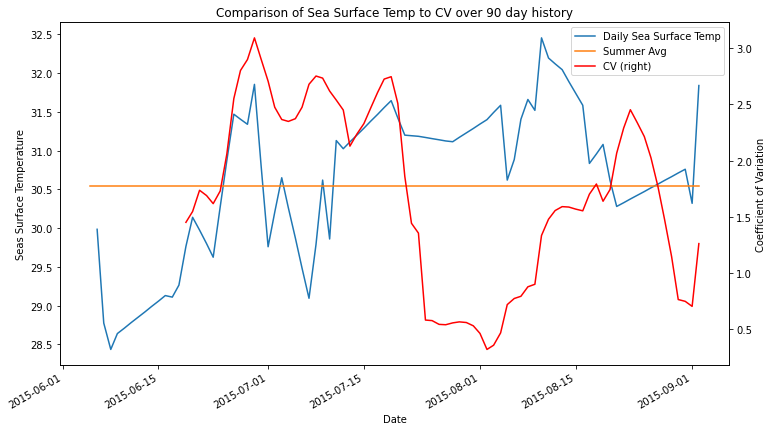

In [30]:
dfExt['Date'] = pd.to_datetime(dfExt['time'], unit='ms')
dfExt = dfExt.rename(columns={'sst_extended':'Daily Sea Surface Temp','sst_Summer':'Summer Avg','sst_cv':'CV'})
plt.figure()
ax = dfExt[['Date','sst','Daily Sea Surface Temp','Summer Avg','CV']].plot(x='Date',y=['Daily Sea Surface Temp','Summer Avg'],title='Comparison of Sea Surface Temp to CV over 90 day history',figsize=(12, 7))
ax.set_ylabel('Seas Surface Temperature')
dfExt.plot(x='Date',y='CV',color='r',secondary_y=True,ax=ax)
plt.ylabel('Coefficient of Variation')

plt.show()

From this history, a sampling of metrics are pulled: max temperature, max summer to acutal difference, cumulative degrees above the summer expectations, number of days above the summertime expectation, max CV, and days with CV above 1.9.

There's also two features for summer corrected CV. In these cases, there's corrections built in for high CVs from decreasing temperatures and at low overall temperatures.

In [15]:
#row['chlor_a'] = df.iloc[0,]['chlor_a']
row['sst_max'] = dfExt['Daily Sea Surface Temp'].max()
row['sst_abv_summer'] = dfExt['sst_SumComp'].loc[(dfExt['sst_SumComp']>1)].count()
row['sst_cv_max'] = dfExt['CV'].max()
row['sst_cv_max_SumComp'] = dfExt['CV'].loc[(dfExt['CV']>=1.9)&(dfExt['sst_SumComp']>0)&(dfExt['Daily Sea Surface Temp']>dfExt['sst_mean'])].max()
row['sst_cv_cnt'] = dfExt['CV'].loc[dfExt['CV']>=1.9].count()
pd.DataFrame(row)

C:\Users\matjo\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\matjo\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


,1370
index,1417
Latitude_Degrees,24.62689
Longitude_Degrees,-81.10751
Percent_Bleached_Sum,39.51
day,3
month,9
year,2015
lat_Rnd,24.5
lon_Rnd,-81.5
sst_max,32.454998


The following functions encapsulate the preceding commands to allow for row by row application.

In [7]:
def Extend_SST(df):
    #This function takes the dataframe created from the MODIS values and creates the features for coefficient of variation (cv)
    #   maximum temperature and the comparison to summertime averages.
    df['sst'] = df['sst'].interpolate()
    dfExt=pd.merge(df,SummerAvgSST,how='left',left_on=['lon_Rnd','lat_Rnd'],right_on = ['Lon','Lat'])
    dfExt['sst_SumComp'] = dfExt['sst']-dfExt['sst_Summer']
    dfExt['sst_sd'] = dfExt['sst'].rolling(14).std()
    dfExt['sst_mean'] = dfExt['sst'].rolling(14).mean()
    dfExt['sst_cv'] = dfExt['sst_sd']*100/dfExt['sst_mean']
    
    return dfExt[['longitude','latitude','time','sst','sst_SumComp','sst_cv','sst_mean']]

In [8]:
def getModisData(row):
    #getModisData takes a row from a dataframe with coordinates + time and pulls the last 90 days of sea surface
    #    temperatures (SST) and a single day snapshot of chlor_a data.  SST data are condensed to count of days above the 
    #    summertime averages for that location, the maximum coefficient of variation and the single day maximum.
    try:
        # Download GEE Modis data for 90 day SST history
        chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['sst'])
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
        image = chlor.filterBounds(geometry=point).filterDate(date.advance(-90, 'day'), date)
        data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
        
        #convert output from GEE to pandas dataframe
        df = pd.DataFrame(data[1:], columns=data[0])
        
        #pass along rounded coordinates
        df['lat_Rnd'] = row['lat_Rnd']
        df['lon_Rnd'] = row['lon_Rnd']
        
        #Calculate statistics from 90 day history
        df = Extend_SST(df)
        
        #If output came out empty, save nans
        if df.shape[0]==0:
            #row['chlor_a'] = np.nan
            row['sst_max'] = np.nan
            row['sst_cv'] = np.nan
            row['sst_hi_cv_cnt'] = np.nan
            row['sst_dayAboveSum'] = np.nan
            
        #If output has one or more rows, compress the values to specific features
        elif df.shape[0] >= 1:
            #row['chlor_a'] = df.iloc[0,]['chlor_a']
            row['sst_day_of_study'] = df['sst'].tail(1)
            row['sst_max'] = df['sst'].max()
            row['sst_summer_max'] = df['sst_SumComp'].max()
            row['sst_cv_max'] = df['sst_cv'].max()
            row['sst_cv_cnt'] = df['sst_cv'].loc[df['sst_cv']>=1.9].count()
            row['sst_abv_summer'] = df['sst_SumComp'].loc[(df['sst_SumComp']>1)].count()
            row['sst_abv_summer_cumulative'] = df['sst_SumComp'].loc[(df['sst_SumComp']>1)].sum()
            row['sst_cv_cnt_SumComp'] = df['sst_cv'].loc[(df['sst_SumComp']>0)&(df['sst']>df['sst_mean'])].count()
            row['sst_cv_max_SumComp'] = df['sst_cv'].loc[(df['sst_SumComp']>0)&(df['sst']>df['sst_mean'])].max()
            row['sst_cv_max_SumComp'] = row['sst_cv_max_SumComp'].fillna(0)
        return row
    except EEException:
        #row['chlor_a'] = np.nan
        row['sst'] = np.nan
        return row

## Running the GCBD database through the Modis data extraction function to pull the expanded feature space

In [9]:
import time
import swifter
st = time.time()

#dfGCBDTest = dfGCBD.sample(300)
#dfGCBDModis = dfGCBDTest.apply(getModisData,axis=1)

dfGCBDModis = dfGCBD.swifter.apply(getModisData,axis=1)

dfGCBDModis.to_csv('Data/ModisDataFull.csv')

et = time.time() 

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Pandas Apply:   0%|          | 0/19250 [00:00<?, ?it/s]

Execution time: 7742.481603145599 seconds


In [10]:
dfGCBDModis

,index,Latitude_Degrees,Longitude_Degrees,Percent_Bleached_Sum,day,month,year,lat_Rnd,lon_Rnd,sst_day_of_study,sst_max,sst_summer_max,sst_cv_max,sst_cv_cnt,sst_abv_summer,sst_abv_summer_cumulative,sst_cv_cnt_SumComp,sst_cv_max_SumComp
0,0,24.366926,124.003372,74.7,8,9,2016,24.5,124.5,"89 29.889999 Name: sst, dtype: float64",32.189999,1.768072,2.866368,19,8,10.707080,25,2.866368
1,1,24.454807,124.109802,74.7,2,9,2016,24.5,124.5,"89 30.449999 Name: sst, dtype: float64",32.184998,1.763071,3.311434,49,18,23.015310,32,3.311434
2,2,24.457072,124.098558,5.0,29,6,2010,24.5,124.5,"89 27.924999 Name: sst, dtype: float64",28.230000,-2.191927,3.284038,33,0,0.000000,0,NaN
3,3,24.463401,123.802185,32.5,5,8,2008,24.5,123.5,"89 28.959999 Name: sst, dtype: float64",30.590000,0.330976,2.554234,25,0,0.000000,2,1.857318
4,4,24.482618,124.125423,74.7,2,9,2016,24.5,124.5,"89 30.404999 Name: sst, dtype: float64",32.445000,2.023073,3.657445,47,8,10.944586,24,3.657445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,38043,12.028167,-61.783111,0.0,18,3,2015,12.5,-61.5,"89 26.24 Name: sst, dtype: float64",28.299999,-1.658545,1.675566,0,0,0.000000,0,NaN
19246,38044,12.045639,-61.764917,0.0,26,3,2015,12.5,-61.5,"89 26.445 Name: sst, dtype: float64",28.225000,-1.733543,1.762488,0,0,0.000000,0,NaN
19247,38045,12.045639,-61.764917,0.0,26,3,2015,12.5,-61.5,"89 26.445 Name: sst, dtype: float64",28.225000,-1.733543,1.762488,0,0,0.000000,0,NaN
19248,38046,12.041444,-61.770944,0.0,11,3,2015,12.5,-61.5,"89 26.51 Name: sst, dtype: float64",28.344999,-1.613544,1.858388,0,0,0.000000,0,NaN


## Visualizing individual features to Percent Bleached through scatterplots

<AxesSubplot:title={'center':'Coral % Bleached vs Max CV in Previous 90 Days (Corrected)'}, xlabel='sst_cv_max_SumComp', ylabel='Percent_Bleached_Sum'>

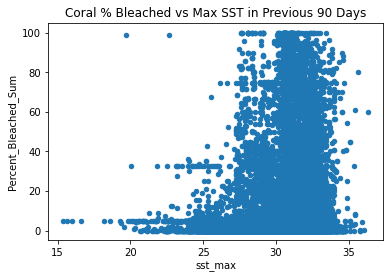

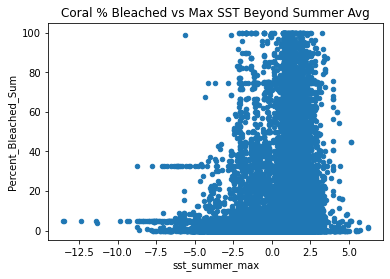

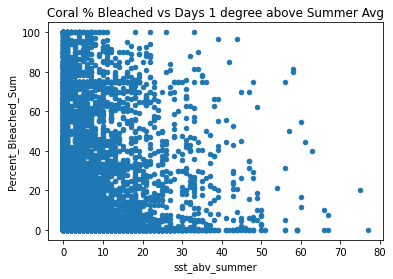

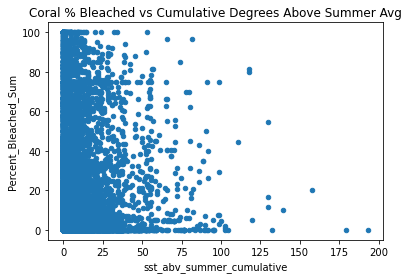

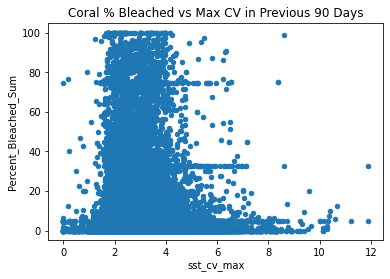

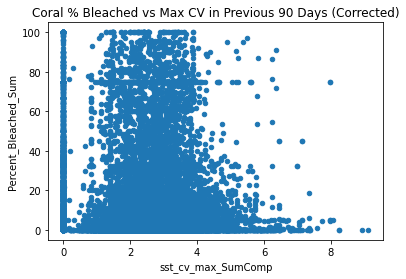

In [26]:
dfGCBDModis[['Percent_Bleached_Sum','sst_max']].plot(kind='scatter',x='sst_max',y='Percent_Bleached_Sum',title='Coral % Bleached vs Max SST in Previous 90 Days')
dfGCBDModis[['Percent_Bleached_Sum','sst_summer_max']].plot(kind='scatter',x='sst_summer_max',y='Percent_Bleached_Sum',title='Coral % Bleached vs Max SST Beyond Summer Avg')
dfGCBDModis[['Percent_Bleached_Sum','sst_abv_summer']].plot(kind='scatter',x='sst_abv_summer',y='Percent_Bleached_Sum',title='Coral % Bleached vs Days 1 degree above Summer Avg')
dfGCBDModis[['Percent_Bleached_Sum','sst_abv_summer_cumulative']].plot(kind='scatter',x='sst_abv_summer_cumulative',y='Percent_Bleached_Sum',title='Coral % Bleached vs Cumulative Degrees Above Summer Avg')
dfGCBDModis[['Percent_Bleached_Sum','sst_cv_max']].plot(kind='scatter',x='sst_cv_max',y='Percent_Bleached_Sum',title='Coral % Bleached vs Max CV in Previous 90 Days')
dfGCBDModis[['Percent_Bleached_Sum','sst_cv_max_SumComp']].plot(kind='scatter',x='sst_cv_max_SumComp',y='Percent_Bleached_Sum',title='Coral % Bleached vs Max CV in Previous 90 Days (Corrected)')
#dfGCBDModis[['Percent_Bleached_Sum','sst_cv_cnt']].plot(kind='scatter',x='sst_cv_cnt',y='Percent_Bleached_Sum',title='Coral % Bleached vs Days above 1.9 CV')
#dfGCBDModis[['Percent_Bleached_Sum','sst_cv_cnt_SumComp']].plot(kind='scatter',x='sst_cv_cnt_SumComp',y='Percent_Bleached_Sum',title='Coral % Bleached vs Days above 1.9 CV (Summer Comp)')

## Comparing features through adjusted R^2 values

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

dfBMTest = dfGCBDModis[['Percent_Bleached_Sum','sst_day_of_study','sst_max','sst_summer_max','sst_cv_max','sst_abv_summer','sst_abv_summer_cumulative','sst_cv_cnt','sst_cv_max_SumComp','sst_cv_cnt_SumComp']].dropna()

y = dfBMTest['Percent_Bleached_Sum'].values.reshape(-1, 1)
x1 = dfBMTest['sst_day_of_study'].values.reshape(-1,1)
x2 = dfBMTest[['sst_max']].values
x3 = dfBMTest[['sst_summer_max']].values
x4 = dfBMTest[['sst_summer_max','sst_cv_max']].values
x5 = dfBMTest[['sst_max','sst_summer_max','sst_cv_max']].values
x6 = dfBMTest[['sst_max','sst_summer_max','sst_cv_max','sst_abv_summer','sst_abv_summer_cumulative']].values
x7 = dfBMTest[['sst_max','sst_summer_max','sst_cv_max','sst_abv_summer','sst_abv_summer_cumulative','sst_cv_cnt']].values
x8 = dfBMTest[['sst_max','sst_summer_max','sst_cv_max','sst_abv_summer','sst_abv_summer_cumulative','sst_cv_cnt','sst_cv_max_SumComp','sst_cv_cnt_SumComp']].values

n = len(dfBMTest)

score1 = LinearRegression().fit(x1, y).score(x1,y)
score1 = 1 - ((1-score1)*(n-1)/(n-1))
score2 = LinearRegression().fit(x2, y).score(x2,y)
score2 = 1 - ((1-score2)*(n-1)/(n-1))
score3 = LinearRegression().fit(x3, y).score(x3,y)
score3 = 1 - ((1-score3)*(n-1)/(n-1))
score4 = LinearRegression().fit(x4, y).score(x4,y)
score4 = 1 - ((1-score4)*(n-1)/(n-2))
score5 = LinearRegression().fit(x5, y).score(x5,y)
score5 = 1 - ((1-score5)*(n-1)/(n-3))
score6 = LinearRegression().fit(x6, y).score(x6,y)
score6 = 1 - ((1-score6)*(n-1)/(n-5))
score7 = LinearRegression().fit(x7, y).score(x7,y)
score7 = 1 - ((1-score7)*(n-1)/(n-6))
score8 = LinearRegression().fit(x8, y).score(x8,y)
score8 = 1 - ((1-score8)*((n-1)/(n-8)))

print('Current Score: ',score1)
print('X2 Score:',score2)
print('X3 Score:',score3)
print('X4 Score:',score4)
print('X5 Score:',score5)
print('X6 Score:',score6)
print('X7 Score:',score7)
print('X8 Score:',score8)



Current Score:  0.017618434131588923
X2 Score: 0.022664307466569444
X3 Score: 0.03753782329847888
X4 Score: 0.04209972629474934
X5 Score: 0.050504958351541784
X6 Score: 0.06037932873912599
X7 Score: 0.0615829058259838
X8 Score: 0.0925381756563145


<AxesSubplot:title={'center':'Improvement of Adjusted R^2 values in Expanding Feature Space'}, xlabel='Features', ylabel='Adjusted R^2'>

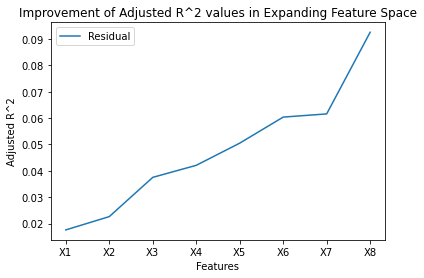

In [31]:
pd.DataFrame({'Features':['X1','X2','X3','X4','X5','X6','X7','X8'],'Residual':[score1,score2,score3,score4,score5,score6,score7,score8]})\
.plot(kind='line',x='Features',y='Residual',ylabel='Adjusted R^2',title='Improvement of Adjusted R^2 values in Expanding Feature Space')

In [27]:
dfGCBDModisFnl = dfGCBDModis.dropna()
dfGCBDModisFnl.to_csv('Expanded_SST.csv')